# Applying the CRISP-DM Method to a Business Problem

# 1. Stage One - Determine Business Objectives and Assess the Situation  <a class="anchor" id="Businessunderstanding"></a>
The Animal classification dataset contains 15 folders of images of dimensions: 224 x 224 x 3  (224x224 in RGB format), containing in average 129 images per folder, suitable for image classification.

Each folder represents one of the following classifiers:


* Bear
* Bird
* Cat
* Cow
* Deer
* Dog
* Dolphin
* Elephant
* Giraffe
* Horse
* Kangaroo
* Lion
* Panda
* Tiger
* Zebra




 ## 1.1 What Questions Are We Trying To Answer? <a class="anchor" id="QA"></a>

* Does the model correctly distinguish among images and classify them correctly?

### 1.2 Success metrics

* Accuracy greater than 80%  on a  test set.

* Consistent performance across all 15 animals on a test set.

* No single class with accuracy below 70%. on a test set



# 2. Stage  Two - Data Understanding <a class="anchor" id="Dataunderstanding"></a>


## 2.1 Initial Data Report <a class="anchor" id="Datareport"></a>
Initial data collection report -


In [ ]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn

!pip install keras
!pip install split-folders
!pip install futures

In [ ]:
# Import Required Libraries
import pandas as pd
import pandas.api.types as pdtypes
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure plots render inline
%matplotlib inline



from google.colab import drive

import splitfolders
import os
from PIL import Image,UnidentifiedImageError

from concurrent.futures import ThreadPoolExecutor, as_completed
from collections import Counter


from tensorflow.keras import layers, models, applications,optimizers
from tensorflow.keras.utils import image_dataset_from_directory

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import preprocess_input


from sklearn.metrics import confusion_matrix


In [ ]:
plt.style.use('bmh')

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_path = "/content/drive/My Drive/Colab Notebooks/Unified Mentor Projects/Datasets/Animal Classification/dataset/"
dataset_path_output = "/content/drive/My Drive/Colab Notebooks/Unified Mentor Projects/Datasets/Animal Classification/dataset_splitted/"

if not os.path.exists(dataset_path_output):
    splitfolders.ratio(dataset_path, output=dataset_path_output, seed=42, ratio=(0.7, 0.2,0.1))




In [ ]:
image_size = (224, 224)
batch_size = 32
seed = 42

train_ds = image_dataset_from_directory(
    dataset_path_output + "train",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)

val_ds = image_dataset_from_directory(
    dataset_path_output + "val",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False,
    seed=seed
)

test_ds = image_dataset_from_directory(
    dataset_path_output + "test",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False,
    seed=seed
)





Found 1354 files belonging to 15 classes.
Found 383 files belonging to 15 classes.
Found 207 files belonging to 15 classes.


In [ ]:
print("Number of train batches: ",len(train_ds))  # number of training batches
print("Number of validation batches: ",len(val_ds))    # number of validation batches
print("Number of test batches: ",len(test_ds))   # number of test batches

Number of train batches:  43
Number of validation batches:  12
Number of test batches:  7


## 2.2 Describe Data <a class="anchor" id="Describedata"></a>


### 2.2.1 Distinct Classes

In [ ]:

class_names = train_ds.class_names
print("All classes in the dataset:")
for i, class_name in enumerate(class_names):
    print(f"{i}: {class_name}")


All classes in the dataset:
0: Bear
1: Bird
2: Cat
3: Cow
4: Deer
5: Dog
6: Dolphin
7: Elephant
8: Giraffe
9: Horse
10: Kangaroo
11: Lion
12: Panda
13: Tiger
14: Zebra


### 2.2.2 Class total

In [ ]:
print(f"\nTotal number of classes: {len(class_names)}")


Total number of classes: 15


### 2.2.3 Image file extensions

In [ ]:
extensions = set()

for root, _, files in os.walk(dataset_path_output):
    for file in files:
        ext = os.path.splitext(file)[1].lower()
        if ext:
            extensions.add(ext)

print("Extensions found:", extensions)

Extensions found: {'.jpg', '.jpeg'}


## 2.4 Initial Data Exploration  <a class="anchor" id="Exploredata"></a>


In [ ]:
def plot_class_distribution(dist_name,dist):
    fig, ax = plt.subplots(figsize=(18, 6))
    class_names = dist.class_names
    class_counts = np.zeros(len(class_names), dtype=int)

    # Count class occurrences in batches
    for images, labels in dist:
        if labels.ndim > 1:  # one-hot
            label_indices = np.argmax(labels, axis=1)
        else:  # integer labels
            label_indices = labels.numpy()

        # Count in one shot
        batch_counts = np.bincount(label_indices, minlength=len(class_names))
        class_counts += batch_counts

    # Plot bars
    bars = ax.bar(class_names, class_counts, color="#4C72B0")


    # Add labels to each bar
    for bar,count in zip(bars, class_counts):
        height = bar.get_height()
        width = bar.get_width()
        x = bar.get_x()
        y = bar.get_y()

        label_text = height
        label_x = x + width / 2
        label_y = y + height / 2

        ax.text(label_x, label_y, f"{label_text:,.1f}", ha="center", va="center",fontweight="bold",fontsize=15)

    ax.set_title(f"{dist_name} Set Distribution",fontsize=30)
    ax.set_xlabel("Classes",fontsize=20)
    ax.set_ylabel("Number of Images",fontsize=20)

    #ax.tick_params(axis="x", rotation=45)

    ax.tick_params(axis="x", labelsize=15)
    ax.tick_params(axis="y", labelsize=15)


    plt.tight_layout()
    plt.show()


def plot_samples(dist,samples_per_class=5):
    plt.figure(figsize=(samples_per_class * 2, len(class_names) * 2))

    for row, class_name in enumerate(class_names):
        # Filter dataset for this class
        imgs = []
        for images, labels in dist.unbatch():
            if int(labels) == row:   # label matches class index
                imgs.append(images.numpy().astype("uint8"))
            if len(imgs) >= samples_per_class:
                break

        # Plot the selected images
        for col, img in enumerate(imgs):
            ax = plt.subplot(len(class_names), samples_per_class, row * samples_per_class + col + 1)
            plt.imshow(img)
            plt.axis("off")
            if col == 0:
                ax.set_title(class_name, fontsize=10, loc="left")

    plt.tight_layout()
    plt.show()

def get_image_sizes(dist, max_workers=8):

    valid_exts = {".jpg", ".jpeg", ".png"}

    def check_size(file_path):
        try:
            with Image.open(file_path) as img:
                return img.size  # (width, height)
        except (OSError, UnidentifiedImageError):
            return None  # Skip corrupted/unreadable files

    # Collect all candidate image paths
    all_files = [
        os.path.join(root, f)
        for root, _, files in os.walk(dataset_path)
        for f in files
        if os.path.splitext(f)[1].lower() in valid_exts
    ]

    sizes = []

    # Run threaded checks
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(check_size, f): f for f in all_files}
        for future in as_completed(futures):
            size = future.result()
            if size:
                sizes.append(size)

    return Counter(sizes)



### 2.4.1 Class distribution

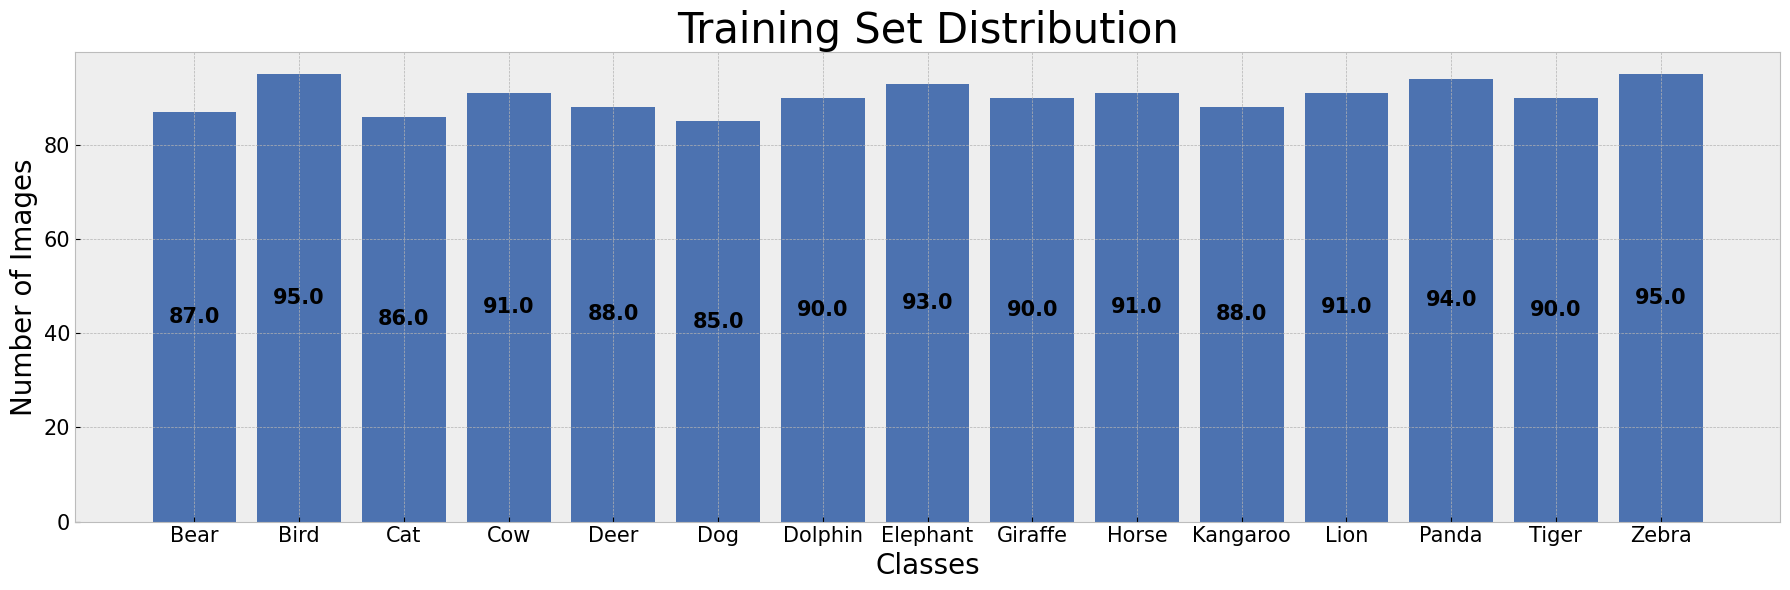

In [ ]:
plot_class_distribution("Training",train_ds)


All 15 classes are balanced. The difference between the most frequent class and the least frequent class is only 10%.

### 2.4.2 Sample visualizations

In [ ]:
plot_samples(train_ds)

Output hidden; open in https://colab.research.google.com to view.

Images contain different variations across classes, which can benefit the training phase even though our dataset has a limited amount of samples.

### 2.4.3 Image resolutions

In [ ]:
size_counts = get_image_sizes(dataset_path, max_workers=8)

print("Most common image sizes:")
for size, count in size_counts.most_common(10):  # top 10
    print(f"{size} -> {count} images")

print(f"\nTotal unique sizes: {len(size_counts)}")

Most common image sizes:
(224, 224) -> 1944 images

Total unique sizes: 1


## 2.5 Data Quality Report <a class="anchor" id="Dataqualityreport"></a>


**Section summary:**
From this information, we can already see that all the images have the same resolution and format(JPG/JPEG). For model development, we will normalize them and ensure that the model only processes JPG files.


# 3. Stage Three - Data Preparation <a class="anchor" id="Datapreperation"></a>


## 3.1 Verify Data Quality <a class="anchor" id="Verifydataquality"></a>



In [ ]:
def find_corrupted_images(dataset_path, max_workers=8):

    # Valid image extensions
    valid_exts = {".jpg", ".jpeg"}

    # Function to check a single image
    def check_image(file_path):
        try:
            with Image.open(file_path) as img:
                img.verify()  # Verify integrity
            return None  # No issue
        except (OSError, UnidentifiedImageError) as e:
            return (file_path, str(e))

    # Collect all files
    all_files = [
        os.path.join(root, f)
        for root, _, files in os.walk(dataset_path)
        for f in files
        if os.path.splitext(f)[1].lower() in valid_exts
    ]

    corrupted_files = []

    # Run checks in parallel
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(check_image, f): f for f in all_files}
        for future in as_completed(futures):
            result = future.result()
            if result:
                corrupted_files.append(result)

    return corrupted_files

In [ ]:

corrupted_files = find_corrupted_images(dataset_path_output, max_workers=8)

if corrupted_files:
    print("Corrupted images found:")
    for f in corrupted_files:
        print(f)
else:
    print("No corrupted images found")

No corrupted images found


**Note:** Outliers removal and normalization process will be made in the next step following steps.

# 4. Stage Four - Modelling <a class="anchor" id="Modelling"></a>



## 4.1. Modelling technique <a class="anchor" id="ModellingTechnique"></a>



**Convolutional Neural Network**

A Convolutional Neural Network (CNN) predicts the category of an image by progressively extracting features. Convolutional layers use filters to detect patterns such as edges, textures, and shapes, while deeper layers combine these into higher-level representations. Finally, the network classifies the image into one category by outputting probabilities.


## 4.2. Build Model <a class="anchor" id="BuildModel"></a>


In [ ]:
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])


In [ ]:
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=2)
]


In [ ]:
def convolutional_global_avg_pooling(num_classes):
    model = models.Sequential([
        layers.Input(shape=(224, 224, 3)),

        layers.Resizing(224, 224),

        data_augmentation,
        layers.Rescaling(1./255),

        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),


        layers.MaxPooling2D((2, 2)),

        layers.GlobalAveragePooling2D(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax') #Multiclass
    ])

    optimizer = optimizers.Adam(learning_rate=0.001)  # Default is 0.001


    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
def convolutional_flatten(num_classes):
    model = models.Sequential([
        layers.Input(shape=(224, 224, 3)),

        layers.Resizing(224, 224),

        data_augmentation,
        layers.Rescaling(1./255),

        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),


        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),

        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax') #Multiclass
    ])

    optimizer = optimizers.Adam(learning_rate=0.001)  # Default is 0.001


    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
def VGG16_flatten_transfer_learning(num_classes):

    base_model = applications.VGG16(weights='imagenet',
                                    include_top=False,
                                    input_shape=(224, 224, 3))

    # Freeze only the convolutional base
    base_model.trainable = False

    model = models.Sequential([
        data_augmentation,
        layers.Lambda(preprocess_input),
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    optimizer = optimizers.Adam(learning_rate=0.001)

    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [ ]:
def VGG16_global_avg_pooling_transfer_learning(num_classes):

    base_model = applications.VGG16(weights='imagenet',
                                    include_top=False,
                                    input_shape=(224, 224, 3))

    # Freeze only the convolutional base
    base_model.trainable = False

    model = models.Sequential([
        data_augmentation,
        layers.Lambda(preprocess_input),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    optimizer = optimizers.Adam(learning_rate=0.001)

    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [ ]:
global_avg_pooling_model=convolutional_global_avg_pooling(num_classes=len(class_names))
global_avg_pooling_model.summary()
history_global_avg_pooling=global_avg_pooling_model.fit(train_ds,validation_data=val_ds,epochs=40,callbacks=callbacks)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │           975 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,455 (240.06 KB)

 Trainable params: 61,455 (240.06 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - accuracy: 0.0577 - loss: 2.7145 - val_accuracy: 0.1123 - val_loss: 2.6992 - learning_rate: 0.0010
Epoch 2/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.1165 - loss: 2.6959 - val_accuracy: 0.1149 - val_loss: 2.6467 - learning_rate: 0.0010
Epoch 3/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.1280 - loss: 2.6331 - val_accuracy: 0.1070 - val_loss: 2.6175 - learning_rate: 0.0010
Epoch 4/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.1368 - loss: 2.5641 - val_accuracy: 0.1645 - val_loss: 2.5922 - learning_rate: 0.0010
Epoch 5/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.1427 - loss: 2.5773 - val_accuracy: 0.1593 - val_loss: 2.5830 - learning_rate: 0.0010
Epoch 6/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - accuracy: 0.1589 - loss: 2.5595 - val_accuracy: 0.1697 - val_loss: 2.5569 - learning_rate: 0.0010
Epoch 7/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.1492 - loss: 2.5363 - val_a

In [ ]:
flatten_model=convolutional_flatten(num_classes=len(class_names))
flatten_model.summary()
history_flatten=flatten_model.fit(train_ds,validation_data=val_ds,epochs=40,callbacks=callbacks)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_1 (Resizing)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     2,768,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 15)             │           975 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,826,255 (10.78 MB)

 Trainable params: 2,826,255 (10.78 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.0833 - loss: 2.7813 - val_accuracy: 0.1044 - val_loss: 2.6465 - learning_rate: 0.0010
Epoch 2/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accuracy: 0.1426 - loss: 2.5898 - val_accuracy: 0.1697 - val_loss: 2.5635 - learning_rate: 0.0010
Epoch 3/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.1749 - loss: 2.5115 - val_accuracy: 0.2272 - val_loss: 2.3594 - learning_rate: 0.0010
Epoch 4/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.2028 - loss: 2.4549 - val_accuracy: 0.2010 - val_loss: 2.4470 - learning_rate: 0.0010
Epoch 5/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.2316 - loss: 2.3926 - val_accuracy: 0.2559 - val_loss: 2.4029 - learning_rate: 0.0010
Epoch 6/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.2451 - loss: 2.3255 - val_accuracy: 0.3003 - val_loss: 2.2113 - learning_rate: 2.0000e-04
Epoch 7/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.2690 - loss: 2.1662 - v

In [ ]:
vgg16_flatten_model=VGG16_flatten_transfer_learning(num_classes=len(class_names))
vgg16_flatten_model.summary()
history_flatten_vgg16=vgg16_flatten_model.fit(train_ds,validation_data=val_ds,epochs=10,callbacks=callbacks)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,141,327 (80.65 MB)

 Trainable params: 6,426,639 (24.52 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 284ms/step - accuracy: 0.4405 - loss: 16.3582 - val_accuracy: 0.8695 - val_loss: 1.3113 - learning_rate: 0.0010
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - accuracy: 0.8880 - loss: 0.7315 - val_accuracy: 0.8956 - val_loss: 0.8491 - learning_rate: 0.0010
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/step - accuracy: 0.9280 - loss: 0.4285 - val_accuracy: 0.9060 - val_loss: 0.7797 - learning_rate: 0.0010
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 162ms/step - accuracy: 0.9449 - loss: 0.2358 - val_accuracy: 0.9164 - val_loss: 0.8775 - learning_rate: 0.0010
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - accuracy: 0.9418 - loss: 0.3258 - val_accuracy: 0.9086 - val_loss: 0.9900 - learning_rate: 0.0010
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - accuracy: 0.9586 - loss: 0.3427 - val_accuracy: 0.9452 - val_loss: 0.7638 - learning_rate: 2.0000e-04
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - accuracy: 0.9798 - loss: 0.0

In [ ]:
vgg16_gap_model=VGG16_global_avg_pooling_transfer_learning(num_classes=len(class_names))
vgg16_gap_model.summary()
history_gap_vgg16=vgg16_gap_model.fit(train_ds,validation_data=val_ds,epochs=10,callbacks=callbacks)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,849,871 (56.65 MB)

 Trainable params: 135,183 (528.06 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 168ms/step - accuracy: 0.3615 - loss: 3.4601 - val_accuracy: 0.8747 - val_loss: 0.4553 - learning_rate: 0.0010
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 162ms/step - accuracy: 0.8807 - loss: 0.4212 - val_accuracy: 0.9060 - val_loss: 0.3103 - learning_rate: 0.0010
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - accuracy: 0.9369 - loss: 0.2373 - val_accuracy: 0.9321 - val_loss: 0.2249 - learning_rate: 0.0010
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - accuracy: 0.9453 - loss: 0.1707 - val_accuracy: 0.9347 - val_loss: 0.1920 - learning_rate: 0.0010
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step - accuracy: 0.9763 - loss: 0.1132 - val_accuracy: 0.9373 - val_loss: 0.1976 - learning_rate: 0.0010
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step - accuracy: 0.9813 - loss: 0.0881 - val_accuracy: 0.9504 - val_loss: 0.1519 - learning_rate: 0.0010
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 162ms/step - accuracy: 0.9778 - loss: 0.0836 - 

# 5. Stage Five - Evaluation <a class="anchor" id="Modelling"></a>


In [ ]:

def plot_confusion_matrix(cm,class_names,title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'shrink': 0.8})
    plt.title(f'Confusion Matrix using {title}', fontsize=16, pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def plot_training_history(history,title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy - check if validation accuracy exists
    ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    if 'val_accuracy' in history.history:
        ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    ax1.set_title(title, fontsize=14)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
    if 'val_loss' in history.history:
        ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    ax2.set_title('Model Loss', fontsize=14)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

## 5.1. Assess Model <a class="anchor" id="AssessModel"></a>


### 5.1.1 Training vs validation accuracy plot

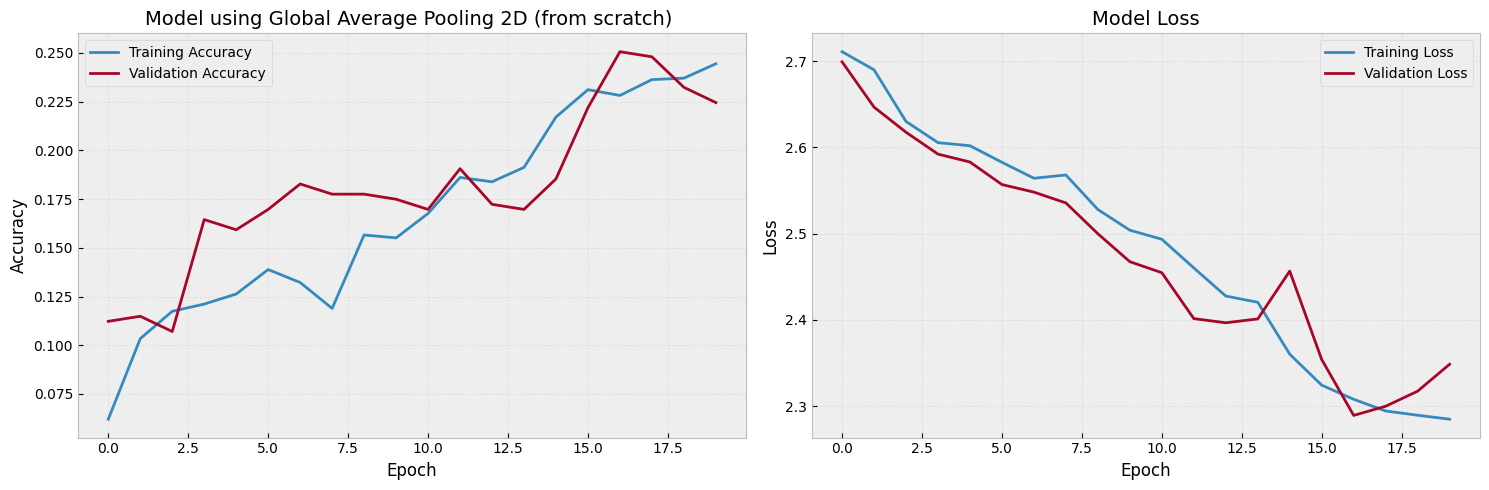

In [ ]:
plot_training_history(history_global_avg_pooling, "Model using Global Average Pooling 2D (from scratch) ")

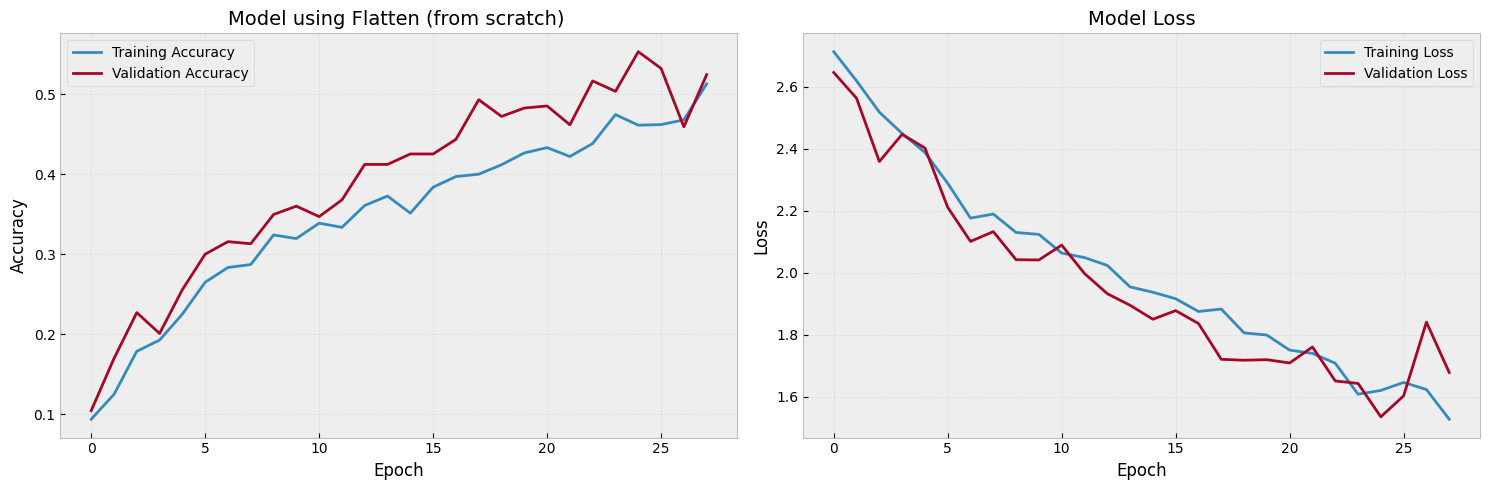

In [ ]:
plot_training_history(history_flatten,"Model using Flatten (from scratch) ")

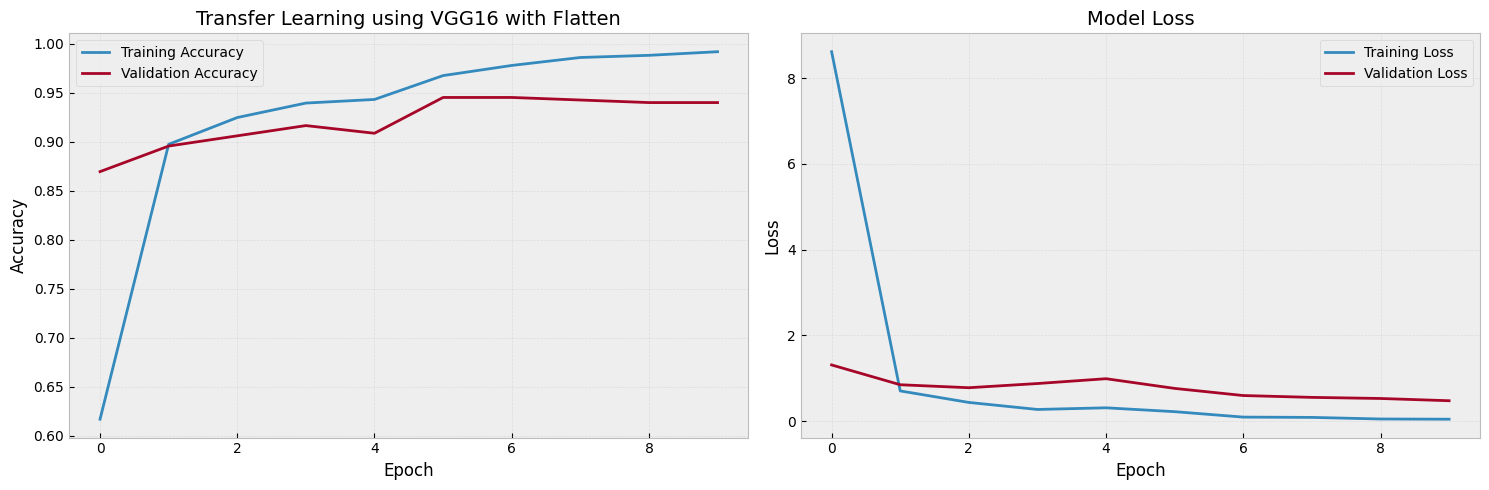

In [ ]:
plot_training_history(history_flatten_vgg16,"Transfer Learning using VGG16 with Flatten")

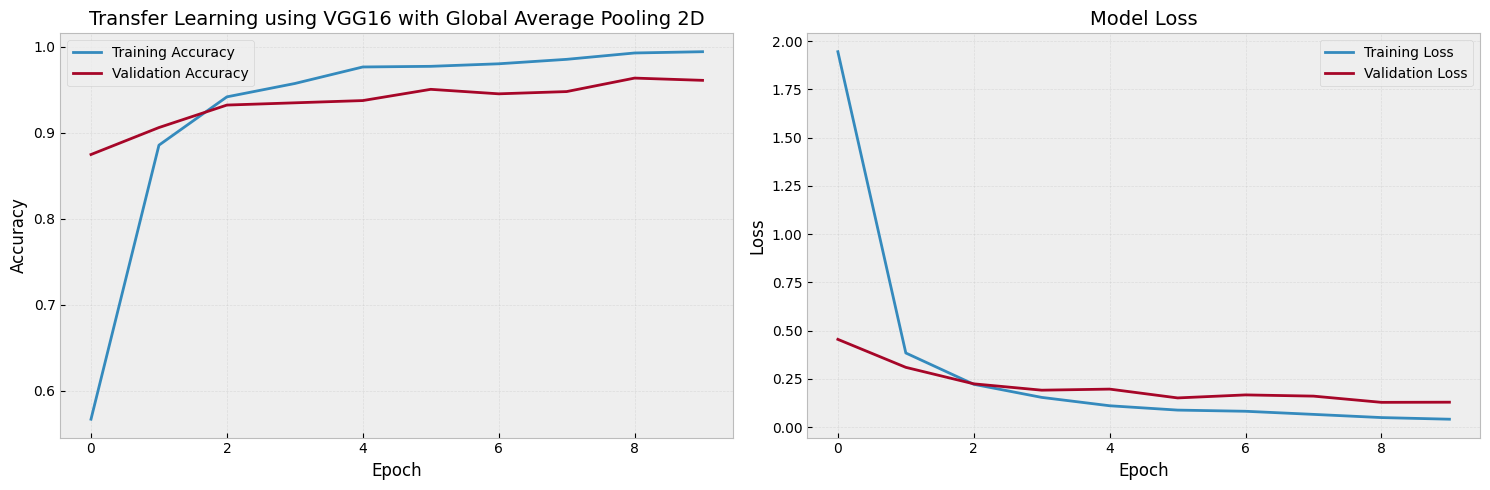

In [ ]:
plot_training_history(history_gap_vgg16,"Transfer Learning using VGG16 with Global Average Pooling 2D")

**Summary**
| Model                       | Train Acc (%) | Val Acc (%) | Train Loss | Val Loss | Observation                          |
|------------------------------|---------------|-------------|------------|----------|--------------------------------------|
| Global Avg Pooling (Scratch) | ~26.5         | ~22.5       | ~2.28      | ~2.58    | Very low accuracy, unstable val loss.|
| Flatten (Scratch)            | ~33.0         | ~42.0       | ~2.00      | ~1.85    | Some improvement, but still weak.    |
| VGG16 + Flatten (Transfer)   | ~96.0         | ~90.0       | ~0.25      | ~1.50    | Strong performance, slight overfit.  |
| VGG16 + GAP (Transfer)       | ~99.0         | ~95.0       | ~0.05      | ~0.20    | Best performance, stable learning.   |



### 5.1.2 Confusion matrix

In [ ]:

# Predictions
y_pred = np.argmax(global_avg_pooling_model.predict(test_ds), axis=1)

# True labels directly from test_ds
y_true = np.concatenate(list(test_ds.map(lambda x, y: y)))

cm = confusion_matrix(y_true, y_pred)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


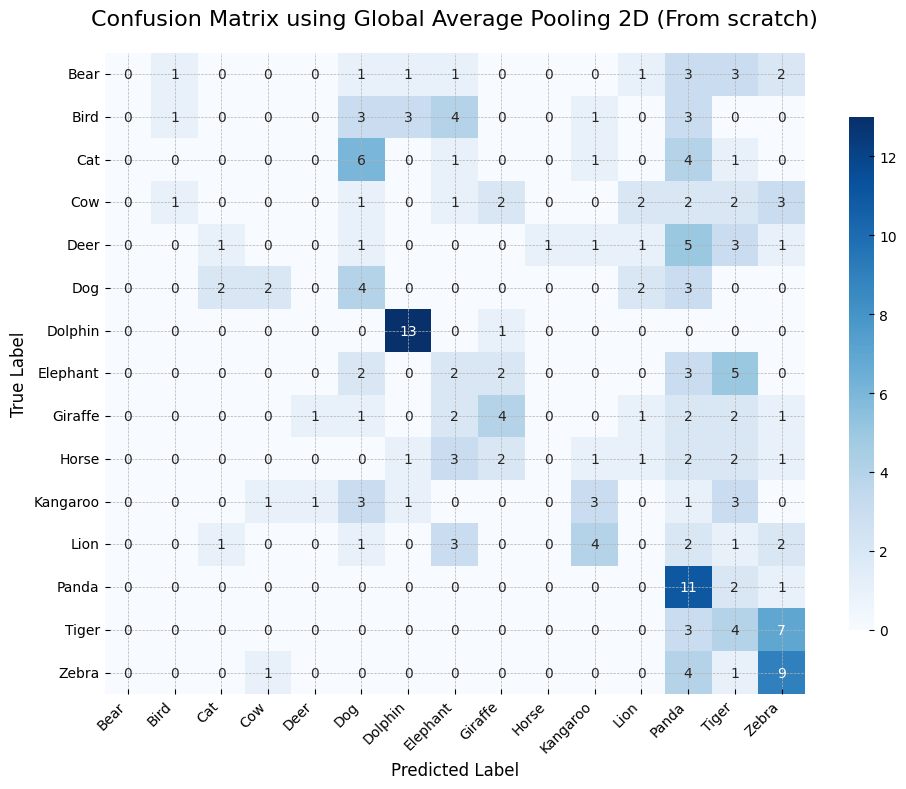

In [ ]:
plot_confusion_matrix(cm,test_ds.class_names,"Global Average Pooling 2D (From scratch)")

In [ ]:
test_loss, test_accuracy = global_avg_pooling_model.evaluate(test_ds, verbose=1)

print(f"\nFinal Results model using Global Average Pooling 2D (from scratch):")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Error: {(1 - test_accuracy)*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.1628 - loss: 2.4146

Final Results model using Global Average Pooling 2D (from scratch):
Test Accuracy: 24.64%
Test Error: 75.36%
Test Loss: 2.2726


In [ ]:

# Predictions
y_pred = np.argmax(flatten_model.predict(test_ds), axis=1)

cm = confusion_matrix(y_true, y_pred)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step


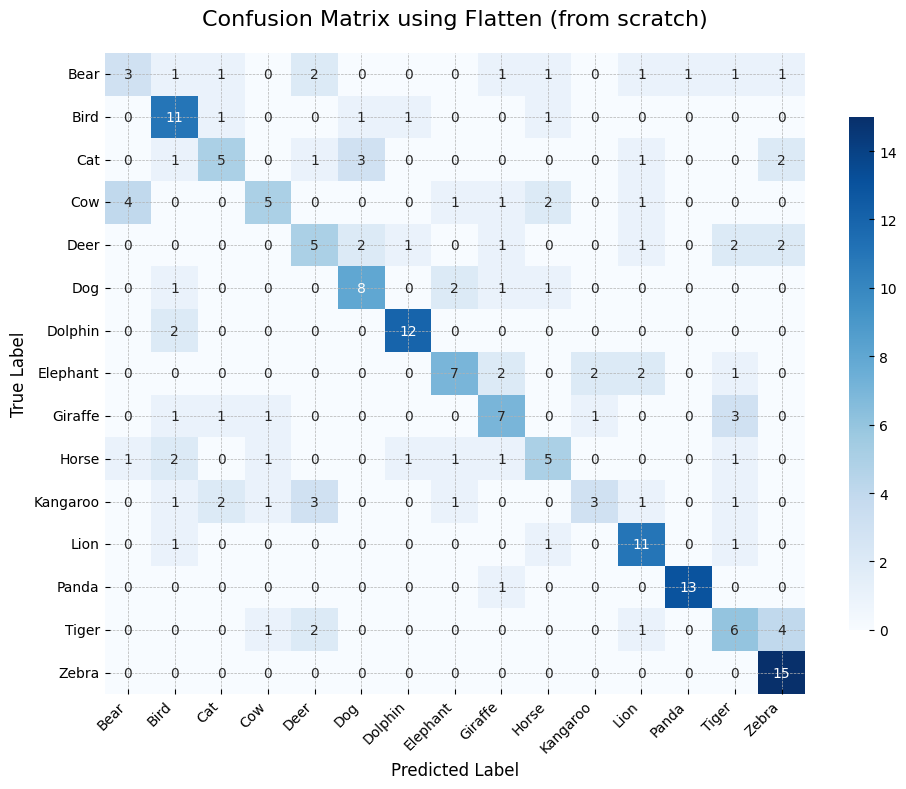

In [ ]:
plot_confusion_matrix(cm, test_ds.class_names,"Flatten (from scratch)")

In [ ]:
test_loss, test_accuracy = flatten_model.evaluate(test_ds, verbose=1)

print(f"\nFinal Results model using Flatten (from scratch):")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Error: {(1 - test_accuracy)*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5013 - loss: 1.7412

Final Results model using Flatten (from scratch):
Test Accuracy: 56.04%
Test Error: 43.96%
Test Loss: 1.5198


In [ ]:
y_pred = np.argmax(vgg16_flatten_model.predict(test_ds), axis=1)

cm = confusion_matrix(y_true, y_pred)

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 424ms/step


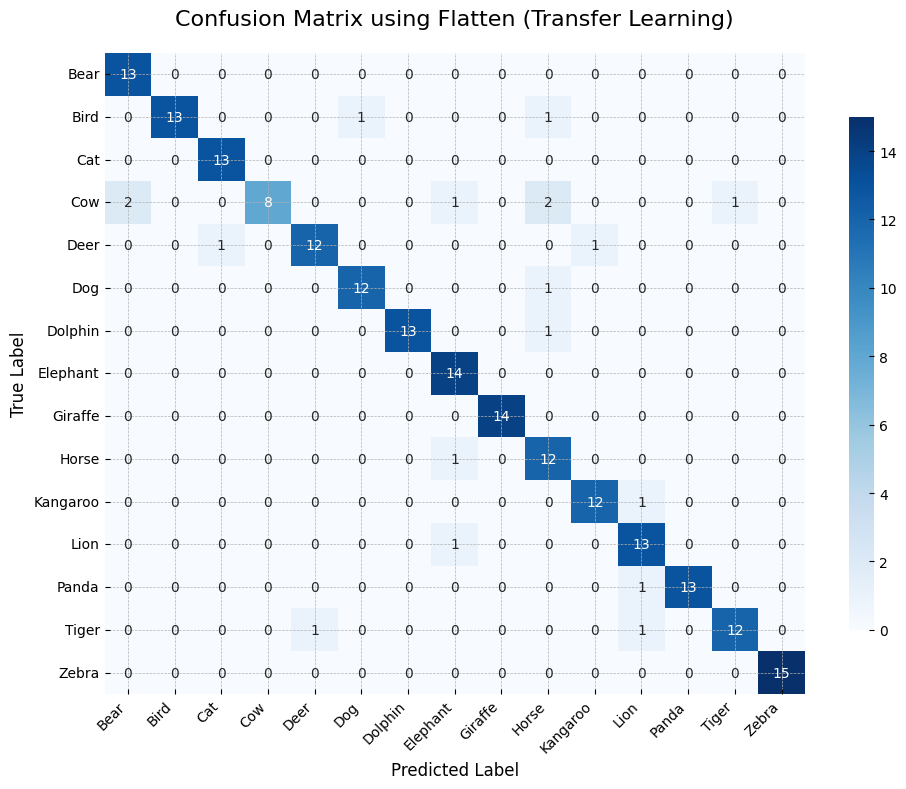

In [ ]:
plot_confusion_matrix(cm,test_ds.class_names,"Flatten (Transfer Learning)")

In [ ]:
test_loss, test_accuracy = vgg16_flatten_model.evaluate(test_ds, verbose=1)

print(f"\nFinal Results model using Transfer learning with VGG16 and Flatten:")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Error: {(1 - test_accuracy)*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.9021 - loss: 1.0443

Final Results model using Transfer learning with VGG16 and Flatten:
Test Accuracy: 91.30%
Test Error: 8.70%
Test Loss: 0.9951


In [ ]:
y_pred = np.argmax(vgg16_gap_model.predict(test_ds), axis=1)

cm = confusion_matrix(y_true, y_pred)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step


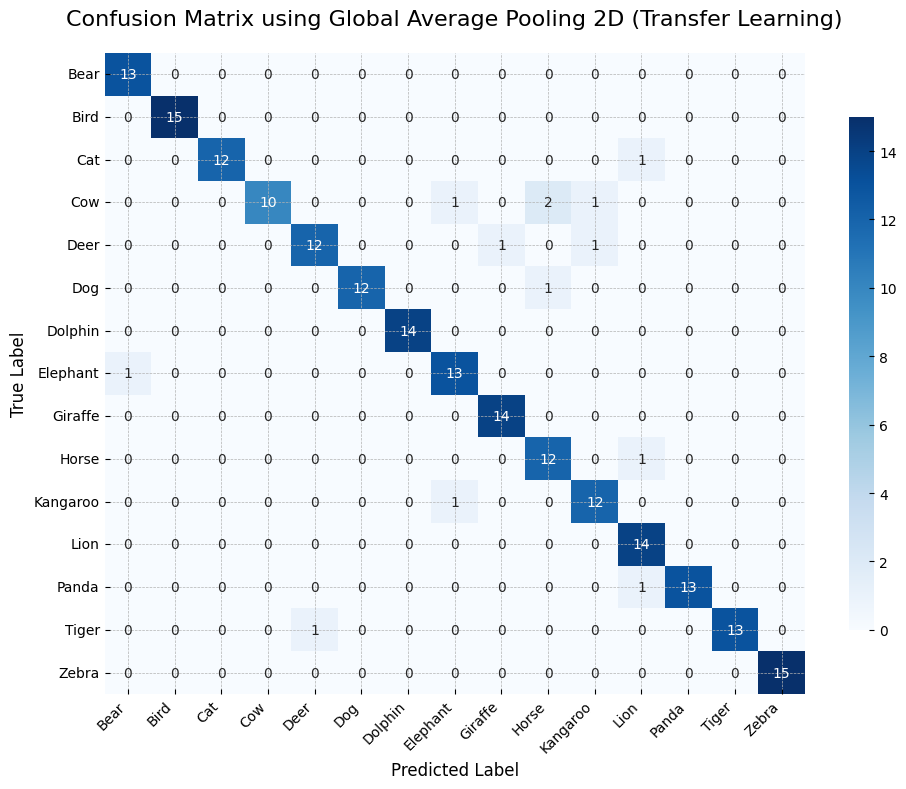

In [ ]:
plot_confusion_matrix(cm,test_ds.class_names,"Global Average Pooling 2D (Transfer Learning)")

In [ ]:
test_loss, test_accuracy = vgg16_gap_model.evaluate(test_ds, verbose=1)

print(f"\nFinal Results model using Transfer learning with VGG16 and Global Average Pooling 2D:")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Error: {(1 - test_accuracy)*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.9353 - loss: 0.2093

Final Results model using Transfer learning with VGG16 and Global Average Pooling 2D:
Test Accuracy: 93.72%
Test Error: 6.28%
Test Loss: 0.2384


**Summary**

| Model                       | Accuracy (%) | Loss  | Error (%) | Observation                                |
|------------------------------|--------------|-------|-----------|--------------------------------------------|
| Global Avg Pooling (Scratch) | 28.02        | 2.3286  |  71.98     | Low accuracy, model failed to learn patterns. |
| Flatten (Scratch)            | 45.89       | 1.8742  | 54.11     | Slightly better, but still poor.           |
| VGG16 + Flatten (Transfer)   | 91.79        | 0.8283  | 8.21      | High accuracy, confident predictions.      |
| VGG16 + GAP (Transfer)       | 92.75       | 0.2557  | 7.25      | Best performance, stable and confident.    |


**Business Success Validation**

**VGG16 + GAP (Transfer)**, which is our selected model, fulfills all success criteria:**

* **Accuracy: 92.75%** (exceeds 80% target)
* **All 15 classes** perform above 70% accuracy threshold
* **Consistent performance** across all animal classes

### 5.1.3 Save the best model

In [ ]:
vgg16_gap_model.save("/content/drive/My Drive/Colab Notebooks/Unified Mentor Projects/Best models/Animalclassification.keras")

# 6. Stage six - Deployment <a class="anchor" id="Deployment"></a>


Still not implemented.